In [1]:
%run Function_Master.ipynb

## Generating Initial Conditions and Parameterization

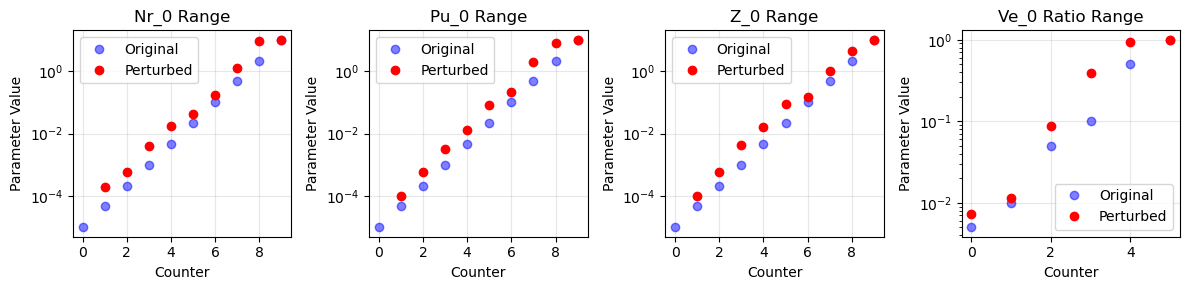

In [3]:
"""
This cell is responsible for generating a list of appropriate initial values
for each state variable. 

The number of values wanted from each defined range is given by the parameter
"points". The values are logarithmically spaced between the ranges to give a
denser representation to smaller values of total nutrients.

Although there is the capability of slightly perturbing each initial value 
for a given state (which would yeild a broader range of total nutrients when
combining the states), that utility is neglected here to ensure we can directly
compare each combination of initial states with the same total nutrient level.
"""
points = 10

N_r_range = np.logspace(-5, 1, points)
P_U_range = np.logspace(-5, 1, points)
Z_range   = np.logspace(-5, 1, points)
V_E_ratio = np.array([1/200, 1/100, 1/20, 1/10, 1/2, 1.])


ranges = [N_r_range, P_U_range, Z_range, V_E_ratio]
range_names = ["Nr_0", "Pu_0", "Z_0", "Ve_0 Ratio"]

perturbed_ranges = perturb_range(ranges, range_names, pprint=True)

In [4]:
#Parameterization

alpha = (1 / 1.42e8) * 2.1e-10 * 1e6 # host conversion, mmol ml / NT m^3
beta  = (1 / 4e5) * 1.27e-15 * 1e6   # viral conversion, mmol ml / NT m^3

V_ind     = 4e5        # NT per individual virus, Table S1
S_ind     = 1.42e8     # NT per individual host, Table S1

V_max     = 1.4              # Host growth rate
γ_Z       = .4               # Growth rate / Assimilation frequency 
φ         = 3.5e-10 / beta   # Viral adsorption rate, m^3 / (mmol * day)
g         = 1.4              # d^-1 Maximum specific grazing rate

ν_x       = V_ind / (V_ind + S_ind) # Proportion of nutrients originating 
                                    # from virus in host-virus pair
    
λ_P       = .05        # Mortality & Respiration rate
λ_Z       = .05        # d^-1, Linear mortality & respiration & egestion
λ_Z_hat   = 0.1        # Quadratic mortality & respiration & egestion
λ_E       = .3         # Extracellular virus mortality 
δ         = .45        # Host lysis rate

μ_V       = .5         # Max host NT recycling rate 
μ_V_prime = 1.6        # Max de novo NT synthesis rate
μ_u       = 0.
μ_r       = 0.         # Viral assimilation fraction related to host mortality
μ_s       = 1.
μ_P       = .4         # Remineralization fraction due to mortality
μ_delta   = .4         # Remineralization fraction due to lysis
μ_g       = .4         # Remineralization fraction due to sloppy-eating
μ_Z       = .4         # Remineralization fraction due to grazer mortality

K_N       = .1         # mmol m^-3 # Half-saturation constant for nutrient limitation
K_I       = 1.         # Half-saturation for light limitation
K_h       = 1.         # Half-saturation for depth of mixed layer ?
K_P       = 2.8        # mmol m^-3, Half-saturation constant for grazing of P
I_0       = (np.e - 1) # Compensation irradiance

ω         = 0. # Entraintment term

param_labels = ['V_max', 'γ_Z', 'φ', 'g', 'ν_x', 'λ_P', 'λ_Z', 'λ_Z_hat', 'λ_E', 
                'δ', 'μ_V', 'μ_V_prime', 'μ_u', 'μ_r', 'μ_s', 'μ_P', 'μ_delta', 
                'μ_g', 'μ_Z', 'K_N', 'K_I', 'K_h', 'K_P', 'I_0', 'ω']

param = [V_max, γ_Z, φ, g, ν_x, λ_P, λ_Z, λ_Z_hat, λ_E, δ, μ_V, μ_V_prime, 
          μ_u, μ_r, μ_s, μ_P, μ_delta, μ_g, μ_Z, K_N, K_I, K_h, K_P, I_0, ω]

In [5]:
print_paramterization(param)

╒════════════════════════════════════════╤═══════════════╤═════════════════╤═══════════════╤══════════════════════╕
│ V_max = 1.4                            │ λ_P = 0.05    │ μ_V = 0.5       │ μ_P = 0.4     │ K_I = 1.0            │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ γ_Z = 0.4                              │ λ_Z = 0.05    │ μ_V_prime = 1.6 │ μ_delta = 0.4 │ K_h = 1.0            │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ φ = 3.5e-10 / beta = 110236.2205       │ λ_Z_hat = 0.1 │ μ_u = 0.0       │ μ_g = 0.4     │ K_P = 2.8            │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ g = 1.4                                │ λ_E = 0.3     │ μ_r = 0.0       │ μ_Z = 0.4     │ I_0 = e - 1 = 1.7183 │
├────────────────────────────────────────┼───────────────┼──────────────

## Running and Sorting Simulations

In [6]:
"""
This cell generates the list of possible initial condition configurations
based on the possible initial ranges generated above. 

The code also defines certain criteria for the numerical integration scheme.

Individual tolerances are perscribed to each state based on knowledge of
their probable values.
"""
t_span = 500

# Remaining state variables usually initiated at the same level (non-random)
Nn_0 = 0.
Pi_0 = 0.
Vi_0 = 0.

NT_cap = 20  # the maximum total nutrients allowed within the system, 
             # defined by the sum of the initial values of all state variables 

max_step   = .1
method     = 'LSODA'
tolerances = [1e-8, 1e-8, 1e-12, 1e-8, 1e-8, 1e-10, 1e-10]
    
#Same order of combinations in a nested for loop
combos = list(product(N_r_range, P_U_range, Z_range, V_E_ratio))

In [7]:
%%time

"""
Numerically integrating equations for each initial condition configuration. 
"""
sols = []

for Nr_0, Pu_0, Z_0, r in combos:
                
    #Initial level of Ve is computed based on the ratio of hosts to viruses
    Ve_0 = est_viral_abund(r, Pu_0, alpha, beta, S_ind, V_ind)
    
    z0 = [Nn_0, Nr_0, Pu_0, Pi_0, Z_0, Vi_0, Ve_0]
    
    if sum(z0) > NT_cap: #if the sum of the initial conditions are
        continue         #greater than the maximum allowable totalN,
                         #then move to next combination
            
    solution = solve_ivp(model, [0, t_span], z0, args=param,
                         max_step=max_step, method=method, atol=tolerances)     
    
    #returns list of initial conditions + solution object
    sols.append((z0, solution))

CPU times: user 3min 11s, sys: 4.27 s, total: 3min 15s
Wall time: 3min 15s


In [8]:
def sort_sols_by_NT(sols):
    """
    Function which sorts solutions based on their level of total N.
    """
    # create a new list of tuples where the first element is the sum 
    #of each tuple and the second element is the original tuple
    sum_tuples = [(sum(z0), z0, sol) for z0, sol in sols]
    
    # sort the new list based on the first element (the sum)
    sorted_sum_tuples = sorted(sum_tuples, key=itemgetter(0))
    
    # extract and return only the original tuples from the sorted list
    return [(z0, sol) for Nt, z0, sol in sorted_sum_tuples]

sols = sort_sols_by_NT(sols)
len(sols)

5832

In [9]:
%store sols 

Stored 'sols' (list)


## Visualization of Results

In [10]:
%store -r sols

In [11]:
#Parameters for printing in plot

param_labels_fp = ['V_max', 'γ_Z', 'φ', 'g', 'ν_x', 
               'λ_P', 'λ_Z', 'λ_Z_hat', 'λ_E', 'δ', 'μ_V', 'μ_V_prime', 'μ_u', 'μ_r', 'μ_s', 
               'μ_P', 'μ_delta', 'μ_g', 'μ_Z', 'K_N', 'K_I', 'K_h', 'K_P', 'I_0 = e - 1', 'ω']

param_fp = [f'{param_labels_fp[i]} = {param[i]:.4}' for i in range(len(param))]
param_fp = np.reshape(param_fp, (5,5)).transpose()

#### Annimation Block

In [12]:
%matplotlib tk

"""
Animation of sorted solutions.
"""

time = [(z0, solution.t) for z0, solution in sols]

Nn = [solution.y[0] for z0, solution in sols]
Nr = [solution.y[1] for z0, solution in sols]
PU = [solution.y[2] for z0, solution in sols]
PI = [solution.y[3] for z0, solution in sols]
Z  = [solution.y[4] for z0, solution in sols]        
VI = [solution.y[5] for z0, solution in sols]
VE = [solution.y[6] for z0, solution in sols]

states = [Nn, Nr, PU, PI, Z, VI, VE]

fig = plt.figure(1, figsize=(12, 10))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax.set_xlim(0, t_span)
ax.set_ylim(0, 10)
    
def animate(i):
    ax.clear()
    ax2.clear()
    
    ax.plot(time[i][1], Nn[i], color="darkviolet", label = "N_n")
    ax.plot(time[i][1], Nr[i], color="blue"      , label = "N_r")
    ax.plot(time[i][1], PU[i], color="aquamarine", label = "P_U")
    ax.plot(time[i][1], PI[i], color="limegreen" , label = "P_I")
    ax.plot(time[i][1], Z[i], color="darkgreen" , label = "Z ")
    ax.plot(time[i][1], VI[i], color="red"       , label = "V_I")
    ax.plot(time[i][1], VE[i], color="darkred"   , label = "V_E")
    
    title = (f'Total N: {sum(time[i][0]):.8}, '
             f'for Nr_0 = {time[i][0][1]:.4}, '
             f'Pu_0 = {time[i][0][2]:.4}, '
             f'Pi_0 = {time[i][0][3]:.4}, '
             f'Z_0 = {time[i][0][4]:.4}, '
             f'Vi_0 = {time[i][0][5]:.4}, '
             f'Ve_0 = {time[i][0][6]:.4}')

    ax.set_title(title, pad=15)
    ax.set(xlabel = 'Time (Day)',
           ylabel = r'Nutrients ($mmol/m^3$)',
           yscale = 'log',
           ylim = (1e-12, 3e1))
    
    ax.grid(which='both', alpha=.3)
    ax.minorticks_on()
    ax.legend(loc=(1.01, 0), framealpha=1)
    
    ax2.text(0, -.2, f"Number of simulations: {len(sols)}", weight='bold', transform=ax.transAxes)
    
    ax2.text(0,-0.29, 'Functional Calls:', weight='bold', transform=ax.transAxes)   
    ax2.text(0,-0.35, f"Integration Method: {method},", transform=ax.transAxes)
    ax2.text(.2, -0.35, f"Max time step: {max_step},", transform=ax.transAxes)
    ax2.text(.35, -0.35, f"Absolute state tolerances: {tolerances}", transform=ax.transAxes)
        
    ax2.text(0, -0.44, f"Number of IC per state: {points}", weight='bold', transform=ax.transAxes)

    # level = -.58
    # for r, state_range in enumerate(perturbed_ranges):
    #     range_for_print = np.array2string(state_range, separator=', ')
    #     ax2.text(0, level, f'{range_names[r]} Values: {range_for_print}', transform=ax.transAxes)
    #     if r < 2:
    #         level -= .12
    #     else: level -= .07
    
    ax2.text(0, -0.53, f"Final state values:", weight='bold', transform=ax.transAxes)
    
    ax2.text(0, -0.60, f"N_n:  {Nn[i][-1]}", transform=ax.transAxes)
    ax2.text(0, -0.65, f"N_r:   {Nr[i][-1]}", transform=ax.transAxes)
    ax2.text(0, -0.70, f"P_U:  {PU[i][-1]}", transform=ax.transAxes)
    ax2.text(0, -0.75, f"P_I:   {PI[i][-1]}", transform=ax.transAxes)
    ax2.text(0, -0.80, f"Z:     {Z[i][-1]}", transform=ax.transAxes)
    ax2.text(0, -0.85, f"V_I:   {VI[i][-1]}", transform=ax.transAxes)
    ax2.text(0, -0.90, f"V_E:  {VE[i][-1]}", transform=ax.transAxes)
    
    ax2.text(0, -0.99, "Parameterization: ", weight='bold', transform=ax.transAxes)

    table = ax2.table(cellText=param_fp, bbox=[0, -.2, 1, .5], cellLoc='left')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(.7, 2)
    
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)

fig.tight_layout(pad=6)
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(sols))
plt.show()

#### File storage

In [13]:
%%time

"""
File storage directly to specified directory; exporting as mp4.
"""
# SET FILE NAME
f = "/Users/jholmes/Desktop/NCAR/Simulation Annimations/Dynamic Initial Configuration/Final-adsoprtion_cutoff-PU_damping_only-@1e-12.mp4"
writermp4 = matplotlib.animation.FFMpegWriter(fps=60)
ani.save(f, writer=writermp4)

CPU times: user 7min 25s, sys: 18.7 s, total: 7min 44s
Wall time: 7min 51s
